# TCN Model on Cascadia
Author: Camilla Billari <br> 
Date: 07/02/24

Fitting a TCN to the Cascadia dataset.

In [1]:
# Import relevant libraries
import matplotlib.pyplot as plt
import pandas as pd

from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    create_features,
    moving_average_causal_filter,
    normalise_dataset,
    normalise_dataset_multi_feature,
    select_features,
    split_train_test_forecast_windows,
)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

# from utils.nn_io import load_model, save_model
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import (
    eval_model_on_test_set,
    eval_model_on_test_set_multi_feature,
    train_model,
    train_model_multi_feature,
)
from utils.plotting import (
    plot_all_data_results,
    plot_eval_test_results,
    plot_example_sample,
    plot_metric_results,
    plot_original_vs_processed_data,
    plot_random_window,
    plot_single_seg_result,
)

In [2]:
# Set random seed
SEED = 17  # random seed for the dataset and model
set_seed(SEED)

# Set torch device
device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


## Load Data

In [3]:
EXP = "cascadia_1_seg"  # select cascadia segment 1

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = dataset.convert_to_df(EXP)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [4]:
# Select segment average and scale down by 10^8
df_seg_1 = pd.DataFrame((df["seg_avg"] / 1e8).rename("signal"))

df_seg_1

,signal
0,1.510314
1,1.256806
2,1.074901
3,1.447256
4,1.787377
...,...
3878,-0.953089
3879,-0.765685
3880,-0.805980
3881,-0.628761


### Optuna optimised hyperparameter results

## Data Pre-processing

### Denoising

In [5]:
# Data smoothing
SMOOTHING_WINDOW = 10  # moving average window size
DOWNSAMPLING_FACTOR = 1

# Smooth the data
df_smoothed = moving_average_causal_filter(
    df_seg_1, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)

df_smoothed.shape

(3874, 1)

In [6]:
# Check if smoothed results are statistically significantly different
results = compare_feature_statistics(df_seg_1, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': array([0.04853684]), 'p_value': array([0.96128966]), 'significant': array([False])}, 'variance_comparison': {'f_statistic': array([0.00235582]), 'p_value': array([0.96128966]), 'significant': array([False])}}


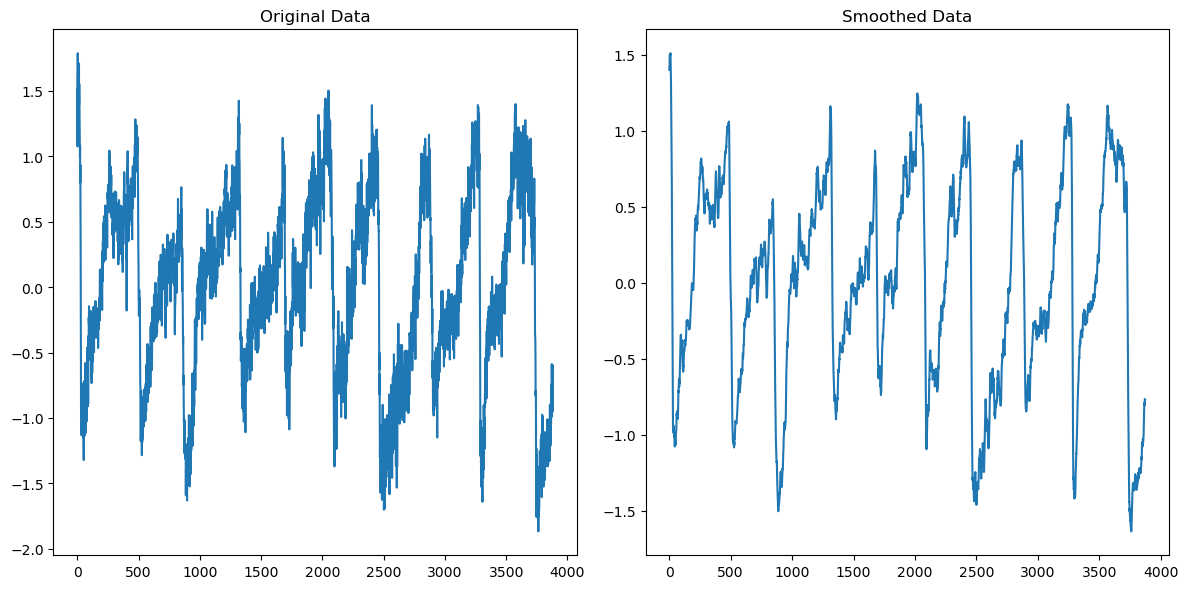

In [7]:
plot_original_vs_processed_data(df_seg_1, df_smoothed, "line")

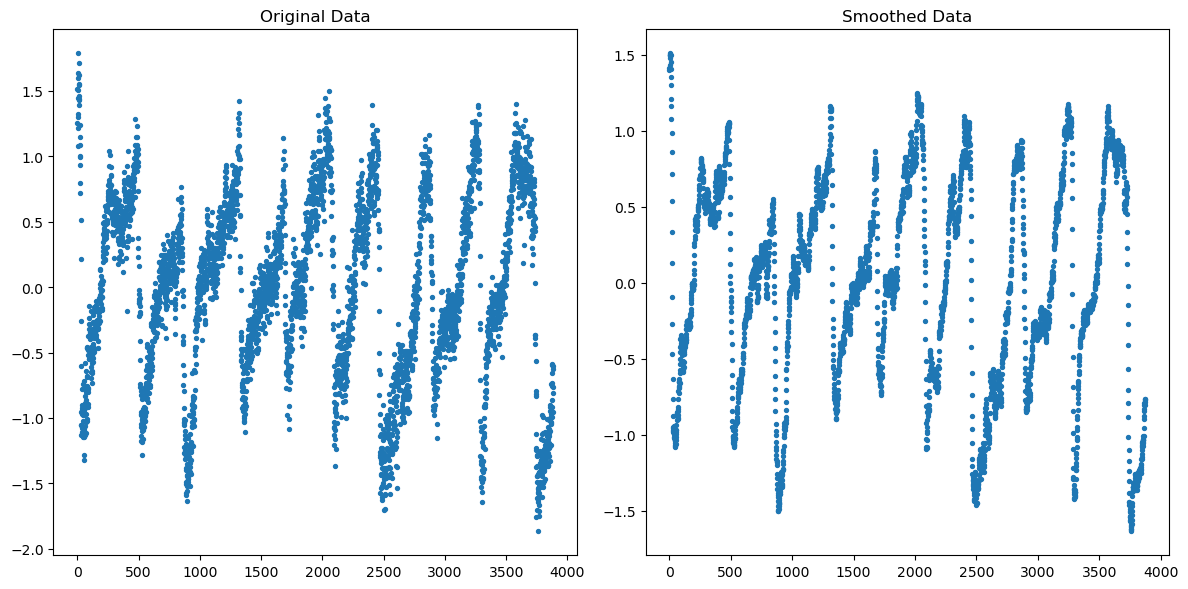

In [8]:
plot_original_vs_processed_data(df_seg_1, df_smoothed, "scatter")

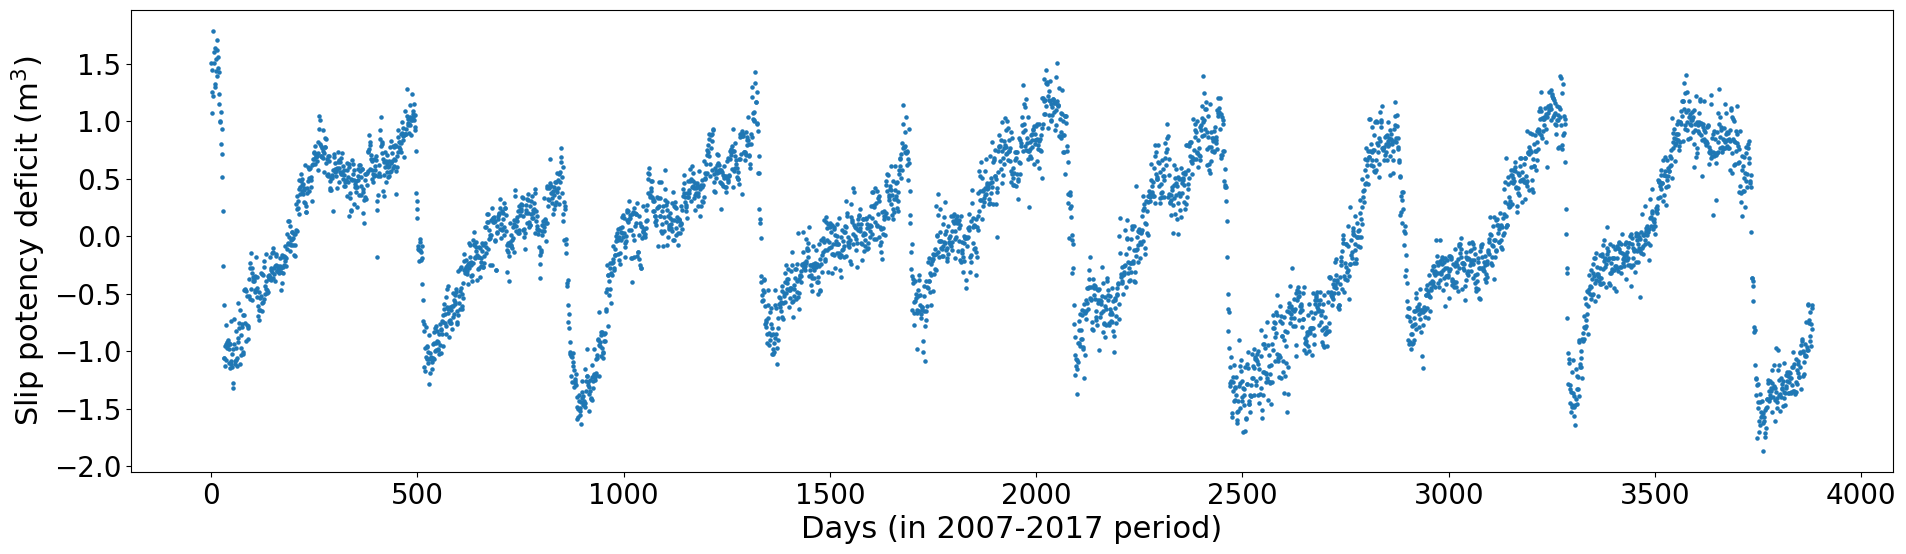

In [9]:
# Create a figure to hold the plots
plt.figure(figsize=(50, 6))
plot_type = "scatter"
s = 5


def plot_scatter(x, y, label):
    plt.scatter(x, y, label=label, s=s)  # Adjust s for smaller dots


# Determine the plotting function based on the plot type
if plot_type == "scatter":
    plot_fn = plot_scatter
else:
    plot_fn = plt.plot

# Plot original data in the first subplot
plt.subplot(1, 2, 1)
plot_fn(range(len(df_seg_1)), df_seg_1, label="Original Data")
plt.ylabel("Slip potency deficit (m$^3$)", fontsize=22)
plt.xlabel("Days (in 2007-2017 period)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title("Original Data")

# Display the plot
plt.show()

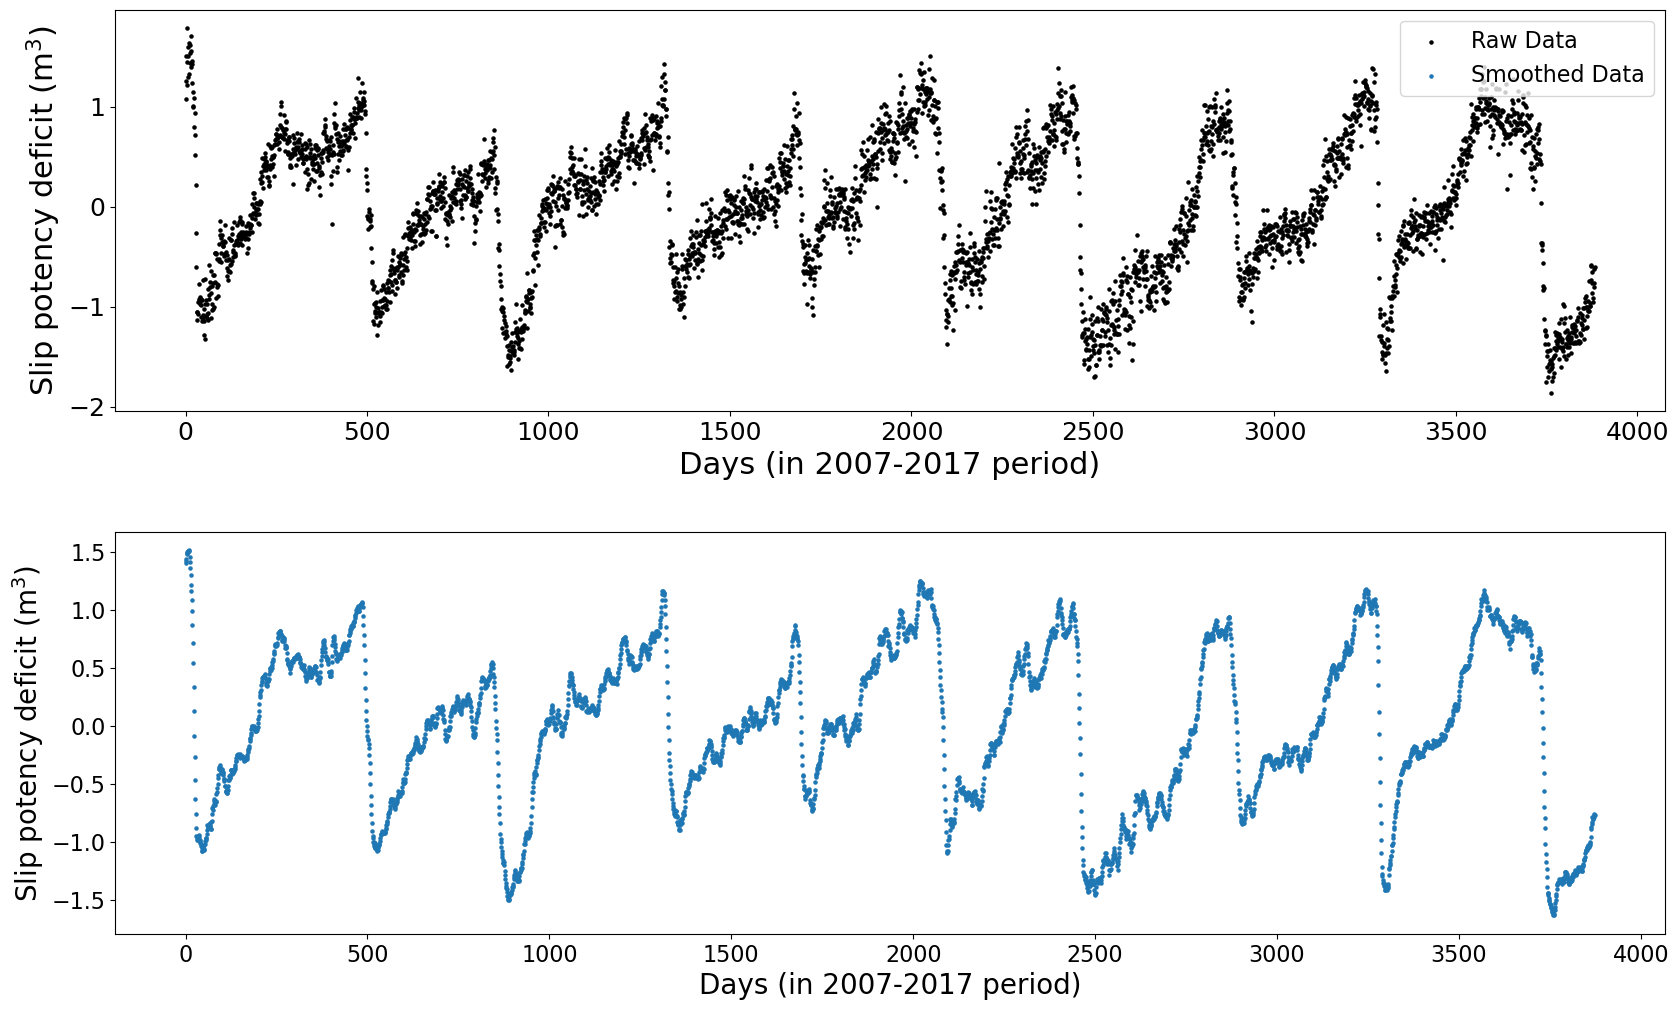

In [10]:
import matplotlib.pyplot as plt

# Assuming df_seg_1 and df_smoothed are your datasets


def plot_scatter(x, y, ax, label, color=None):
    ax.scatter(
        x, y, label=label, s=5, color=color
    )  # Adjust s for smaller dots


# Create a figure to hold the plots with adjusted size for better visibility in a single column layout
# plt.figure(figsize=(20, 12))  # Adjusted figure size for vertical layout
plot_type = "scatter"
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 12))  # 2 Rows, 1 Column

# fig.subplots_adjust(hspace=0.5)  # Adjust the space between subplots


# Plot original data in the first subplot
# axs[0] = plt.subplot(2, 1, 1)  # Adjusted for two plots in a single column
plot_scatter(
    range(len(df_seg_1)), df_seg_1, axs[0], label="Raw Data", color="black"
)
axs[0].set_ylabel("Slip potency deficit (m$^3$)", fontsize=22)
axs[0].set_xlabel("Days (in 2007-2017 period)", fontsize=22)
axs[0].tick_params(axis="both", which="major", labelsize=18)
# ax1.legend()

# Plot smoothed data in the second subplot
# axs[1] = plt.subplot(2, 1, 2)  # Adjusted for two plots in a single column
plot_scatter(
    range(len(df_smoothed)), df_smoothed, axs[1], label="Smoothed Data"
)
axs[1].set_ylabel("Slip potency deficit (m$^3$)", fontsize=20)
axs[1].set_xlabel("Days (in 2007-2017 period)", fontsize=20)
axs[1].tick_params(axis="both", which="major", labelsize=16)
# ax2.legend()

# # Adjust space between subplots
# fig.subplots_adjust(hspace=0.2)  # Adjust the space between subplots


# Creating a joint legend for both subplots
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
fig.legend(
    handles, labels, loc="upper right", fontsize=16, bbox_to_anchor=(0.9, 0.88)
)

fig.subplots_adjust(hspace=0.3)  # Adjust the space between subplots
# fig.suptitle("\n")

# Display the plot
plt.show()

In [11]:
df_features = create_features(df_smoothed.copy())
feature_list = df_features.columns

df_features

,signal,variance,first_derivative,second_derivative,steps_since_last_peak,steps_since_last_trough
0,-0.877885,0.632824,-0.113951,0.014851,29.0,29.0
1,-0.948660,0.728420,-0.070775,0.043176,30.0,30.0
2,-0.983353,0.814668,-0.034693,0.036083,31.0,31.0
3,-0.968042,0.884977,0.015311,0.050003,32.0,32.0
4,-0.972746,0.939554,-0.004705,-0.020015,33.0,33.0
...,...,...,...,...,...,...
3840,-0.802925,0.015242,0.003873,0.021008,301.0,108.0
3841,-0.782701,0.015831,0.020223,0.016350,302.0,109.0
3842,-0.764081,0.016494,0.018620,-0.001603,303.0,110.0
3843,-0.767052,0.016753,-0.002971,-0.021591,304.0,111.0


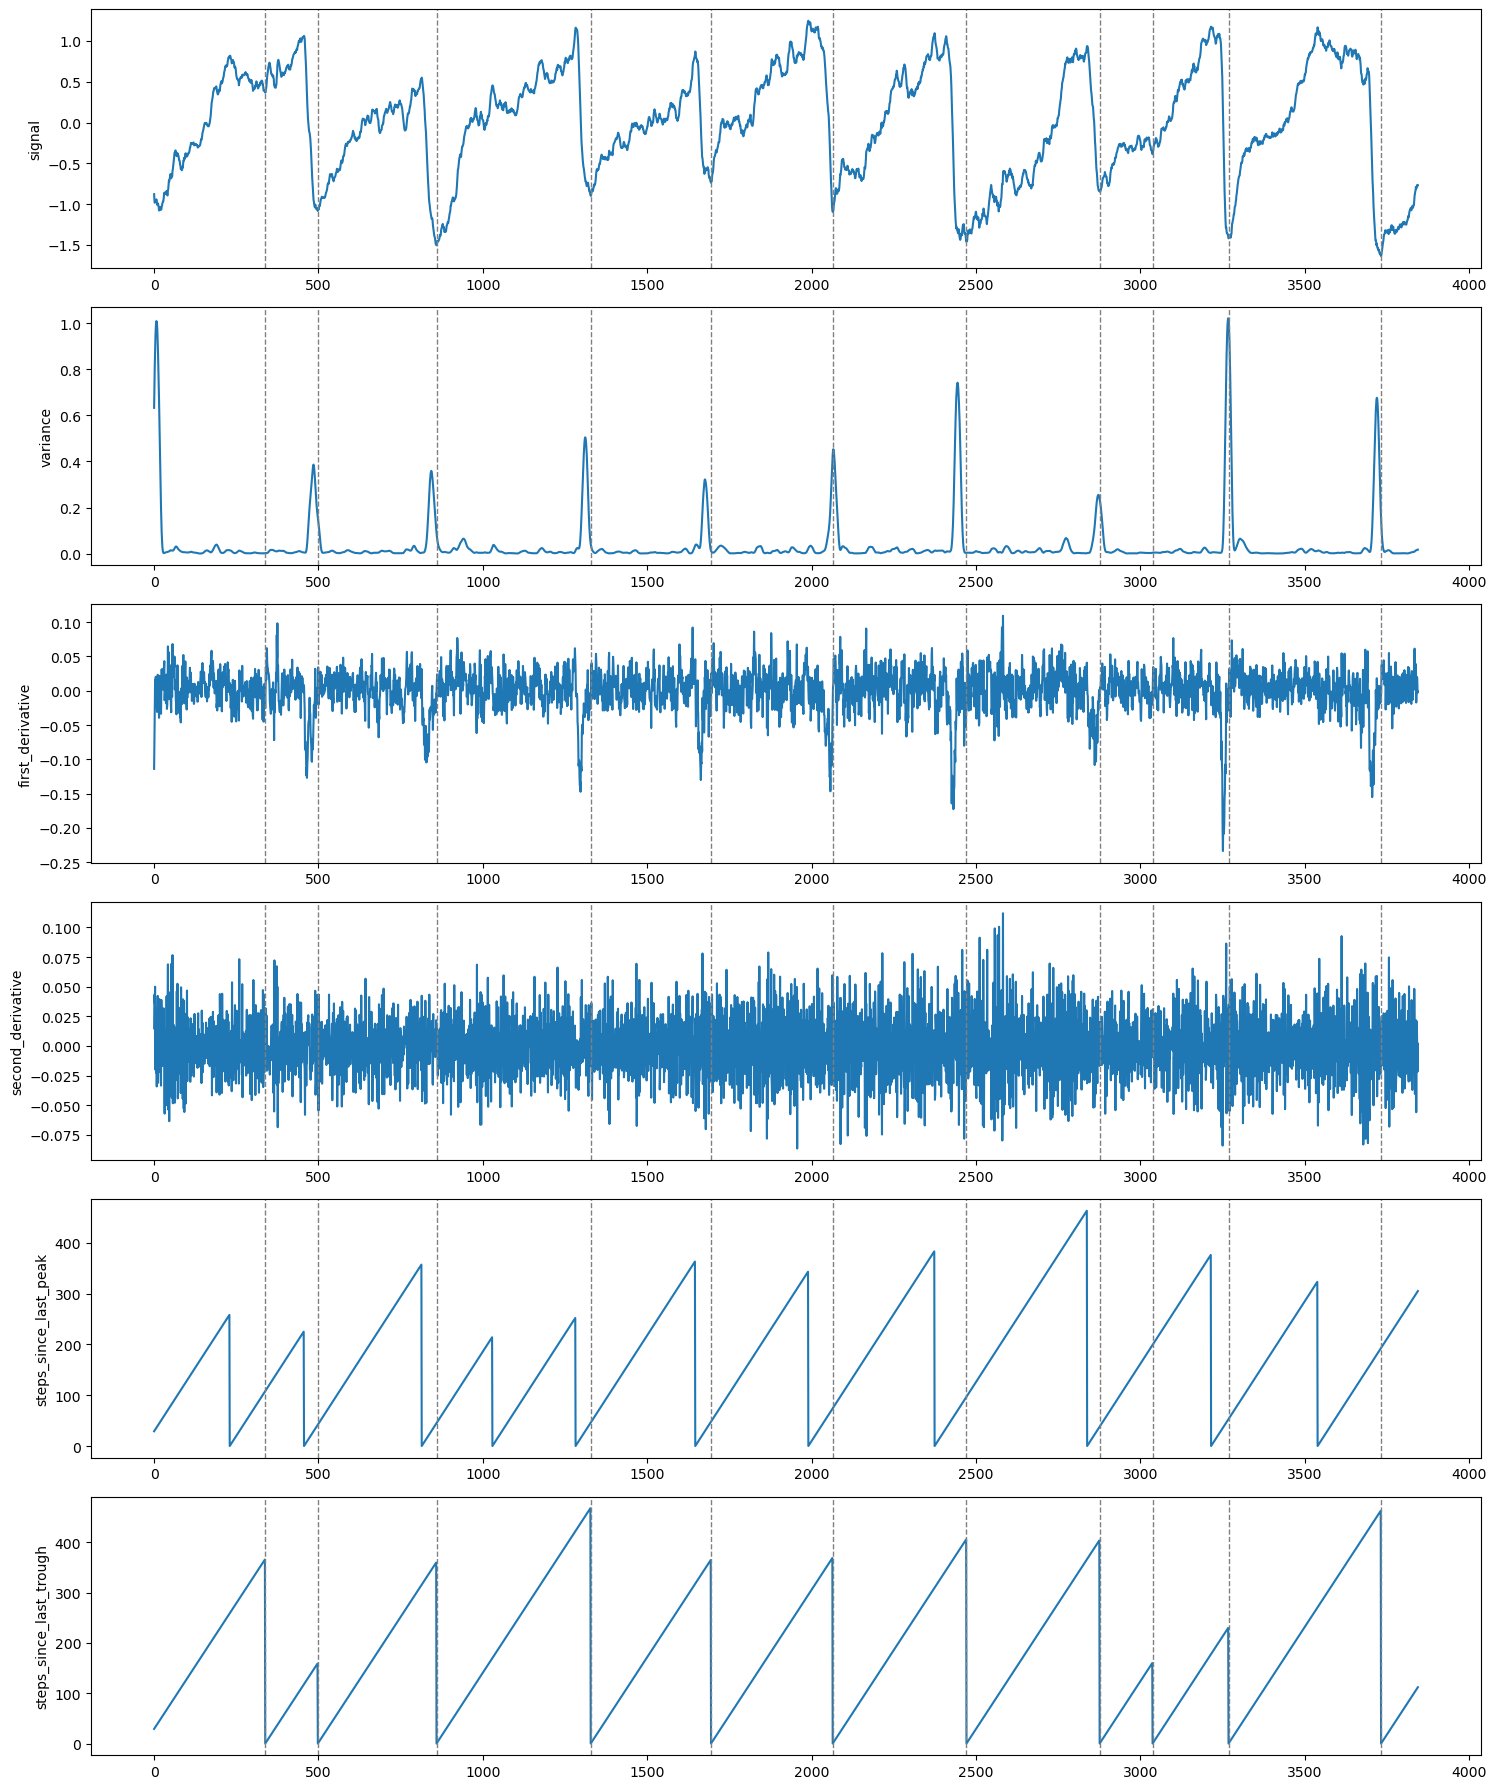

In [12]:
fig, axs = plt.subplots(
    len(df_features.columns), 1, figsize=(15, 3 * len(df_features.columns))
)

for i, column in enumerate(df_features.columns):
    ax = axs[i]
    ax.plot(df_features.index, df_features[column])
    ax.set_ylabel(column)
    ax.grid(False)

    # Mark where steps_since_last_trough = 0 with a black dashed line
    troughs_indices = df_features[
        df_features["steps_since_last_trough"] == 0
    ].index
    for trough_index in troughs_indices:
        ax.axvline(x=trough_index, color="grey", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

## Creating the datastet

In [13]:
# Dataset parameters
LOOKBACK, FORECAST = (
    190,
    30,
)  # lookback and forecast values, lookback is optuna optimised
N_FORECAST_WINDOWS = 15  # n forecasted windows in test set
N_VALIDATION_WINDOWS = 15  # n forecasted windows in validation set

# Pre-process the data into windows
X, y = create_dataset(df_features, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3626, 190, 6]), torch.Size([3626, 30, 6])


In [14]:
# Split into train and test sets and normalise it
(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")
print(f"Validation data shapes: {X_val.shape}, {y_val.shape}")

Training data shapes: torch.Size([2700, 190, 6]), torch.Size([2700, 30, 6])
Testing data shapes: torch.Size([450, 190, 6]), torch.Size([450, 30, 6])
Validation data shapes: torch.Size([450, 190, 6]), torch.Size([450, 30, 6])


### Normalising with scaler based on the training set

In [15]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
scaler = "standard"  # Set to either standard or min-max
data_dict, scalers_X, scalers_y = normalise_dataset_multi_feature(
    X_train, y_train, X_test, y_test, X_val, y_val
)

print(f"Data Dictionary keys:\t{data_dict.keys()}")
print("------------------")
print("Original dataset shapes:")
print(
    f"Training data shapes:\t\t{data_dict['X_train'].shape}\t\t{data_dict['y_train'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_val'].shape}\t\t{data_dict['y_val'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_test'].shape}\t\t{data_dict['y_test'].shape}"
)
print("------------------")
print("Normalised dataset shapes:")
print(
    f"Training data shapes:\t\t{data_dict['X_train_sc'].shape}\t\t{data_dict['y_train_sc'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_val_sc'].shape}\t\t{data_dict['y_val_sc'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_test_sc'].shape}\t\t{data_dict['y_test_sc'].shape}"
)

Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
------------------
Original dataset shapes:
Training data shapes:		torch.Size([2700, 190, 6])		torch.Size([2700, 30, 6])
Testing data shapes:		torch.Size([450, 190, 6])		torch.Size([450, 30, 6])
Validation data shapes:		torch.Size([450, 190, 6])		torch.Size([450, 30, 6])
------------------
Normalised dataset shapes:
Training data shapes:		torch.Size([2700, 190, 6])		torch.Size([2700, 30, 6])
Validation data shapes:		torch.Size([450, 190, 6])		torch.Size([450, 30, 6])
Testing data shapes:		torch.Size([450, 190, 6])		torch.Size([450, 30, 6])


In [20]:
data_dict["y_train"][:, 0, 0].shape

torch.Size([2700])

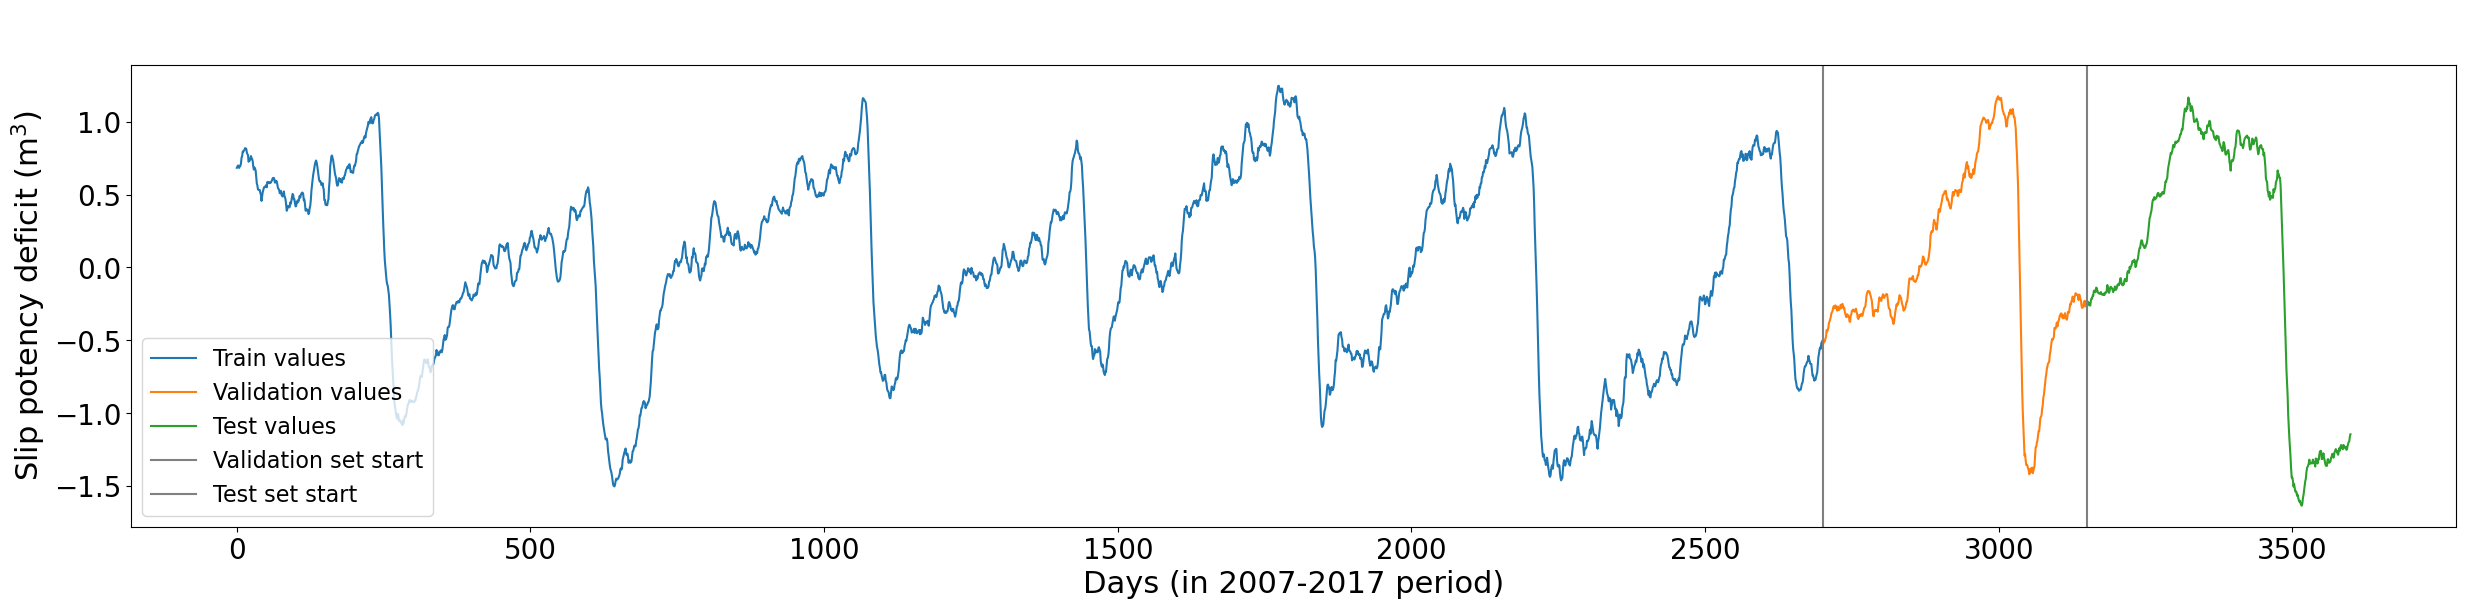

In [28]:
import numpy as np

plot_type = "scatter"
lookback, forecast = LOOKBACK, FORECAST
title = "\n \n"
x_label = "Days (in 2007-2017 period)"
y_label = "Slip potency deficit (m$^3$)"
s = 5
zoom_window = []

plt.figure(figsize=(30, 6))


def plot_scatter(x, y, label):
    plt.scatter(x, y, label=label, s=s)  # Adjust s for smaller dots


# Determine the plotting function based on the plot type
if plot_type == "scatter":
    plot_fn = plot_scatter
else:
    plot_fn = plt.plot

train_plot, val_plot, test_plot = (
    data_dict["y_train"][:, 0, 0],
    data_dict["y_val"][:, 0, 0],
    data_dict["y_test"][:, 0, 0],
)

# Plot train values
plt.plot(
    np.arange(len(train_plot)),
    train_plot,
    label="Train values",
)

# Plot val values
plt.plot(
    range(len(train_plot), len(train_plot) + len(val_plot)),
    val_plot,
    label="Validation values",
)

# Plot val values
plt.plot(
    range(
        len(train_plot) + len(val_plot),
        len(train_plot) + len(val_plot) + len(test_plot),
    ),
    test_plot,
    label="Test values",
)

# Plot vertical axis to indicate start of val/test data
plt.axvline(
    x=len(train_plot),
    color="gray",
    label="Validation set start",
)
# Plot vertical axis to indicate start of val/test data
plt.axvline(
    x=len(train_plot) + len(val_plot),
    color="gray",
    label="Test set start",
)

# Set plot title, labels, and legend
plt.title(title)
plt.xlabel(x_label, fontsize=22)
plt.ylabel(y_label, fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower left", fontsize=16)

# Display the plot
plt.show()

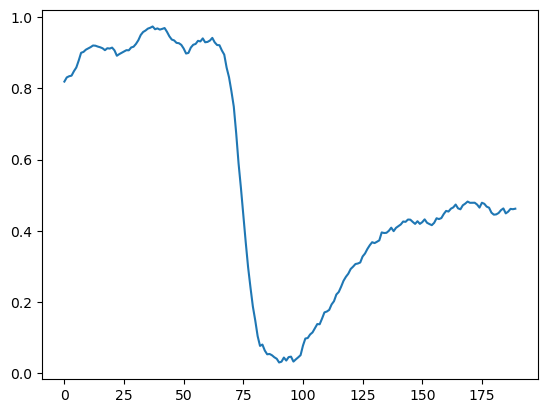

In [16]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :, 0])

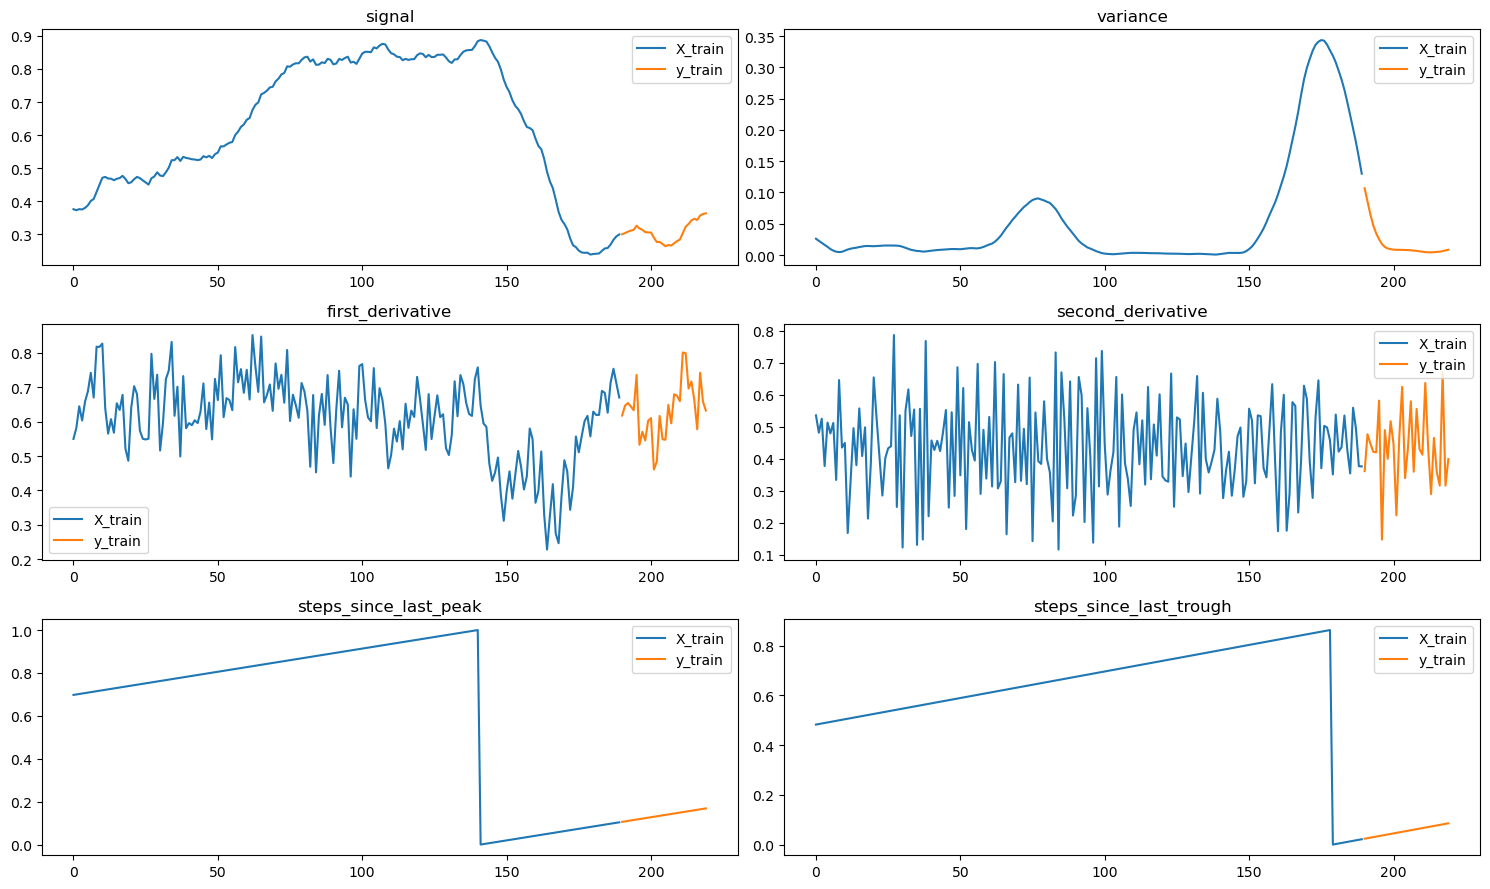

In [17]:
plot_random_window(data_dict, feature_list)

## Modelling

In [18]:
# Select features: signal + fist_derivative gives best Cascadia TCN performance
features_to_keep = [
    "signal",
    "first_derivative",
]  # Include one or more of the following variables "signal", "variance", "first_derivative", "second_derivative", "steps_since_last_peak", "steps_since_last_trough"

data_dict = select_features(data_dict, features_to_keep)

print(f"Data Dictionary keys:\t{data_dict.keys()}")
print("------------------")
print("Original dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict['X_train'].shape}\t\t{data_dict['y_train'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_val'].shape}\t\t{data_dict['y_val'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_test'].shape}\t\t{data_dict['y_test'].shape}"
)
print("------------------")
print("Normalised dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict['X_train_sc'].shape}\t\t{data_dict['y_train_sc'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_val_sc'].shape}\t\t{data_dict['y_val_sc'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_test_sc'].shape}\t\t{data_dict['y_test_sc'].shape}"
)

Data Dictionary keys:	dict_keys(['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val', 'X_train_sc', 'X_test_sc', 'X_val_sc', 'y_train_sc', 'y_test_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([2700, 190, 2])		torch.Size([2700, 30])
Testing data shapes:		torch.Size([450, 190, 2])		torch.Size([450, 30])
Validation data shapes:		torch.Size([450, 190, 2])		torch.Size([450, 30])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([2700, 190, 2])		torch.Size([2700, 30])
Validation data shapes:		torch.Size([450, 190, 2])		torch.Size([450, 30])
Testing data shapes:		torch.Size([450, 190, 2])		torch.Size([450, 30])


In [19]:
# For TCN config as optimised by optuna
N_VARIATES = data_dict["X_train"].shape[2]
HIDDEN_SIZE = 64
KERNEL_SIZE = 8
OUTPUT_SIZE = FORECAST
DROPOUT = 0.14794473280897968

# N of epochs
N_EPOCHS = 300

model = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)

### Training

In [20]:
# For TCN training
results_dict = train_model_multi_feature(
    model, N_EPOCHS, data_dict, scalers_y[0], device
)

Training model on cuda


Best Epoch: 81, Val RMSE: 0.3098 | Last Epoch: [300/300], Train RMSE: 0.0639, Val RMSE: 0.3582: 100%|██████████| 300/300 [03:27<00:00,  1.45it/s]


In [21]:
results_dict = eval_model_on_test_set_multi_feature(
    model, results_dict, data_dict, scalers_y[0], device
)

## Results

Five lowest validation RMSEs:
Epoch: 81, Value: 0.3098302185535431 (R^2: 0.7536545387532025)
Epoch: 96, Value: 0.3127210736274719 (R^2: 0.749058532875857)
Epoch: 98, Value: 0.31559738516807556 (R^2: 0.7444010095513767)
Epoch: 83, Value: 0.3186056911945343 (R^2: 0.739516274163815)
Epoch: 32, Value: 0.3192910850048065 (R^2: 0.7383991232239222)


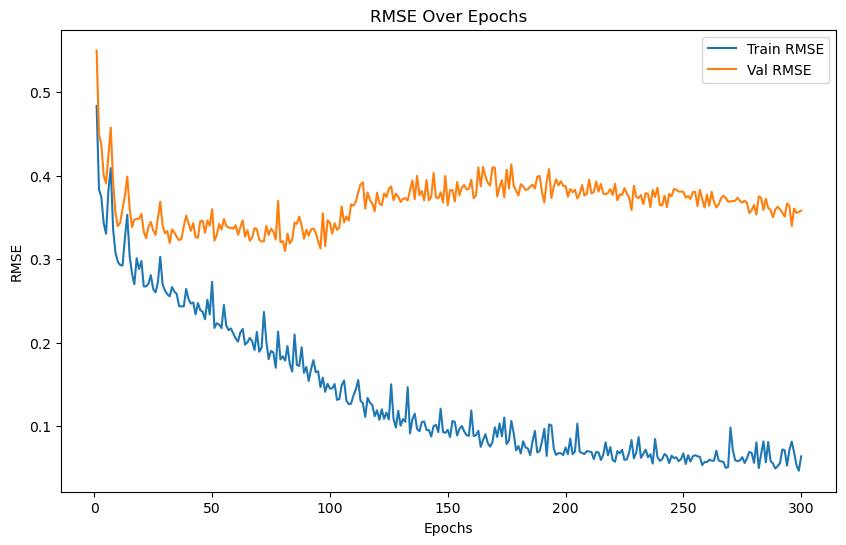

In [22]:
# Identify and print the five lowest validation RMSEs and their corresponding epochs and R^2 values
best_5_epochs = []

print("Five lowest validation RMSEs:")
for index, loss in sorted(
    enumerate(results_dict["val_rmse_list"]), key=lambda x: x[1]
)[:5]:
    best_5_epochs.append(index)
    print(
        f"Epoch: {index + 1}, Value: {loss} (R^2: {results_dict['val_r2_list'][index]})"
    )

# Plot RMSE
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["val_rmse_list"],
    "RMSE",
    val_or_test="Val",
)

Five highest validation R2s:
Epoch: 81, Value: 0.7536545387532025, (RMSE: 0.3098302185535431)
Epoch: 96, Value: 0.749058532875857, (RMSE: 0.3127210736274719)
Epoch: 98, Value: 0.7444010095513767, (RMSE: 0.31559738516807556)
Epoch: 83, Value: 0.739516274163815, (RMSE: 0.3186056911945343)
Epoch: 32, Value: 0.7383991232239222, (RMSE: 0.3192910850048065)


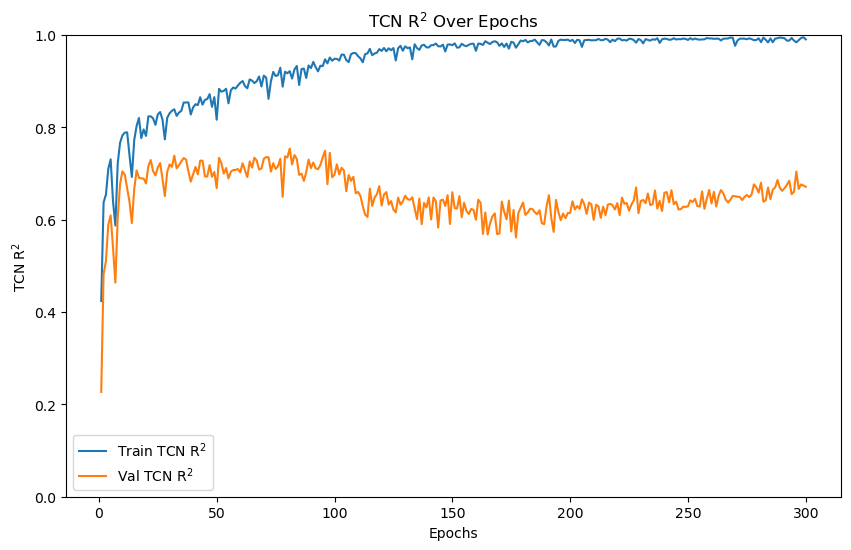

In [23]:
# Identify and print the five lowest validation RMSEs and their corresponding epochs and R^2 values
print("Five highest validation R2s:")
for index, r2 in sorted(
    enumerate(results_dict["val_r2_list"]), key=lambda x: x[1], reverse=True
)[:5]:
    print(
        f"Epoch: {index + 1}, Value: {r2}, (RMSE: {results_dict['val_rmse_list'][index]})"
    )

# Plot R2
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["val_r2_list"],
    "TCN R$^2$",
    y_max=1,
    val_or_test="Val",
)

In [24]:
best_5_epochs[1]

95

In [25]:
print(f'Val RMSE: {results_dict["val_rmse_list"][best_5_epochs[0]]}')
print(f'Val R2: {results_dict["val_r2_list"][best_5_epochs[0]]}')

Val RMSE: 0.3098302185535431
Val R2: 0.7536545387532025


In [26]:
print(f'Test RMSE: {results_dict["best_test_rmse"]}')
print(f'Test R2: {results_dict["best_test_r2"]}')

Test RMSE: 0.33423280715942383
Test R2: 0.8642450615460112


In [27]:
# Plot predictions against true values
# TITLE = "Original Time Series and TCN Predictions of Segment 1 sum"
TITLE = ""
X_LABEL = "Samples"
Y_LABEL = "Slip potency deficit (m$^3$)"

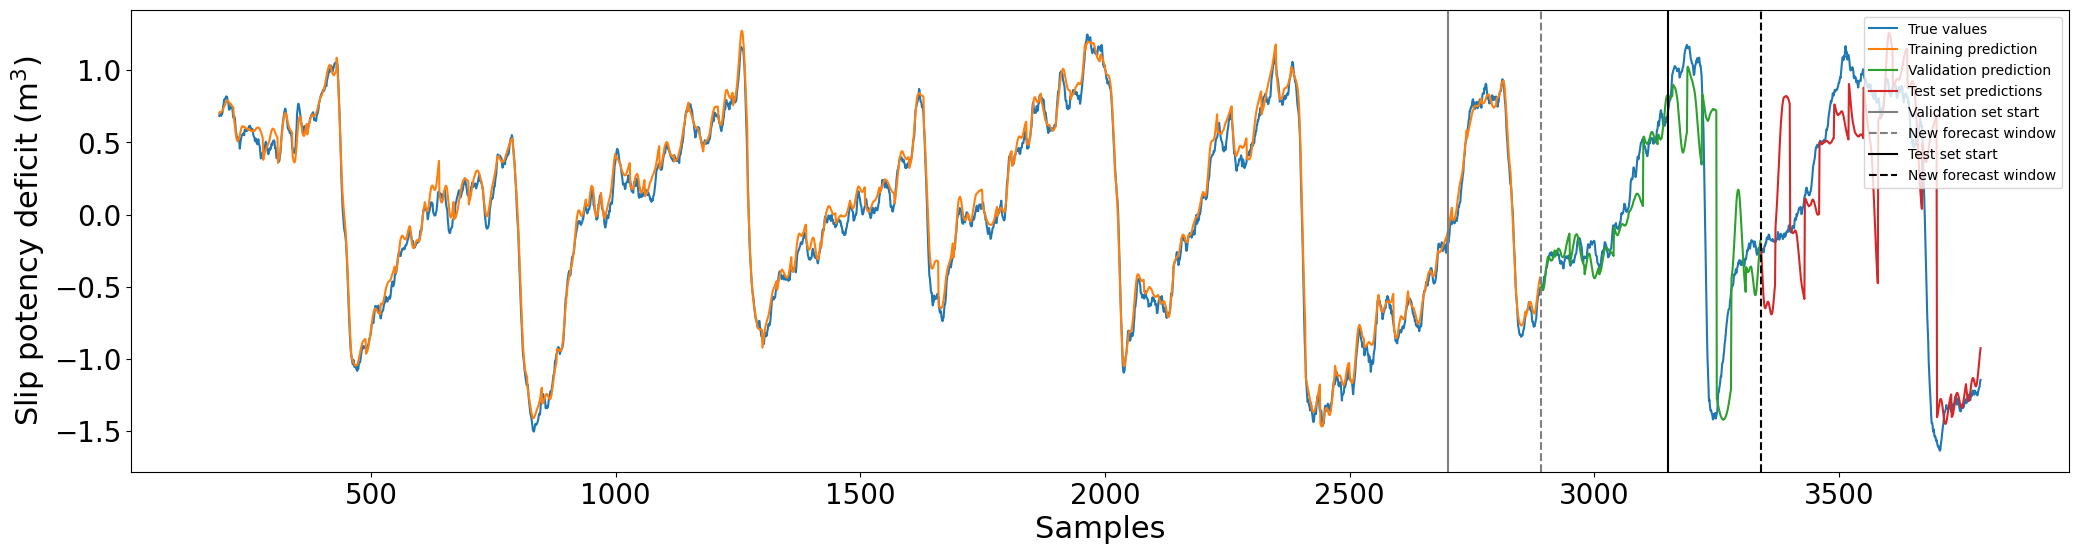

In [28]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)
# TODO: CHANGE HORRIBLE COLOURS

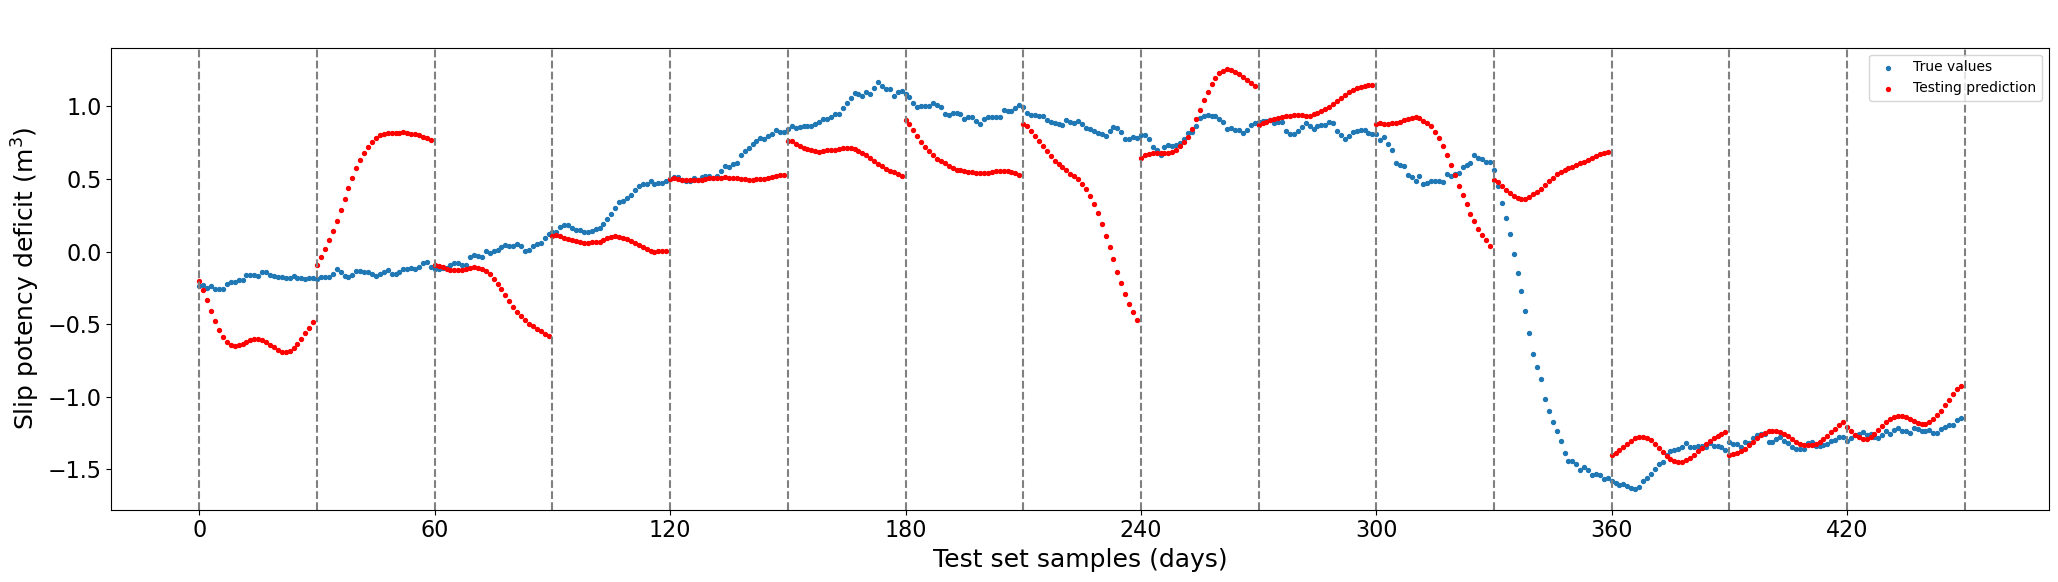

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot predictions against true values
# TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
TITLE = "\n"
X_LABEL = "Test set samples (days)"
Y_LABEL = "Slip potency deficit (m$^3$)"

plot_eval_test_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    plot_type="scatter",
    save_plot=True,
)

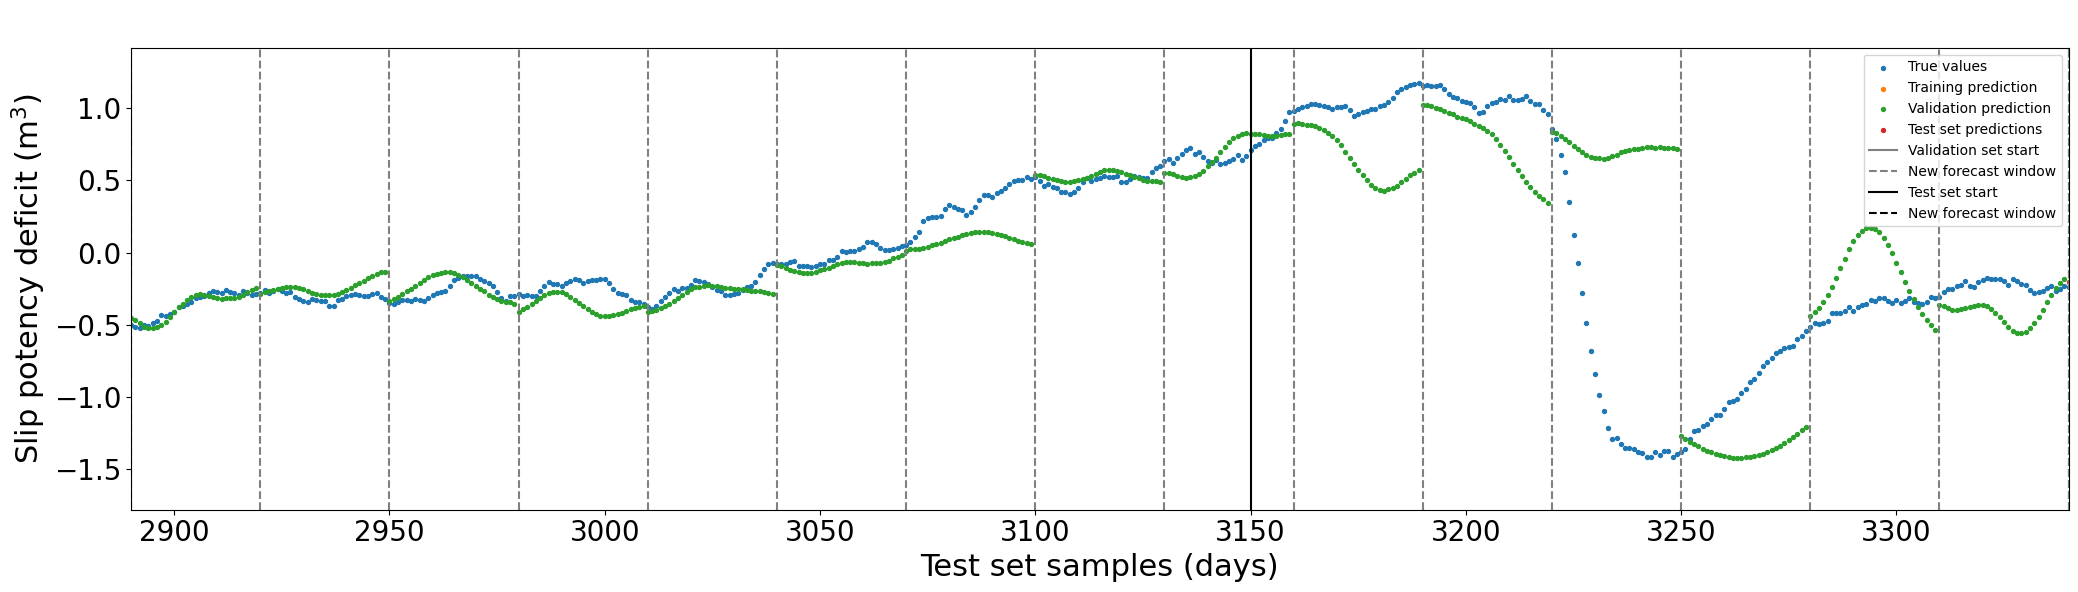

<Figure size 640x480 with 0 Axes>

In [30]:
ZOOM_WINDOW = [2890, 3340]
ZOOM_WINDOW_1st_DER = [2900, 3370]

plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
    plot_type="scatter",
    save_plot=True,
)

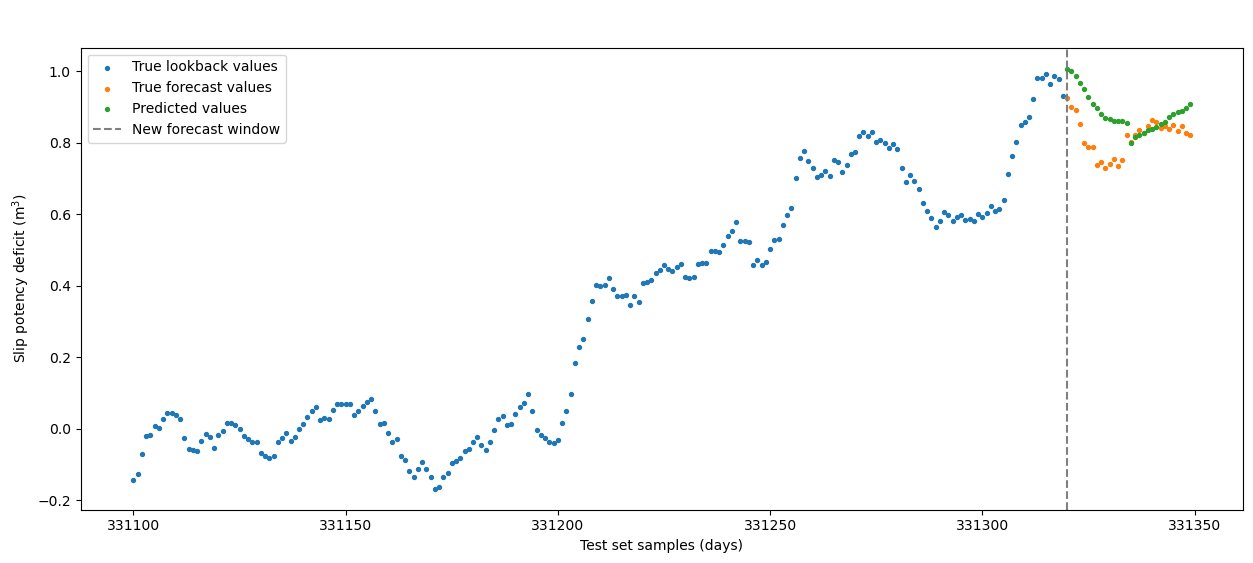

In [31]:
plot_single_seg_result(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    1505,
    TITLE,
    X_LABEL,
    Y_LABEL,
    save_plot=False,
)

In [32]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

# with torch.no_grad():
loss = array_loss_fn(y_test_pred, y_test_true)

rmse = np.sqrt(loss)
avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
test_rmse_first = np.sqrt(loss[:, 0])
test_rmse_last = np.sqrt(loss[:, -1])

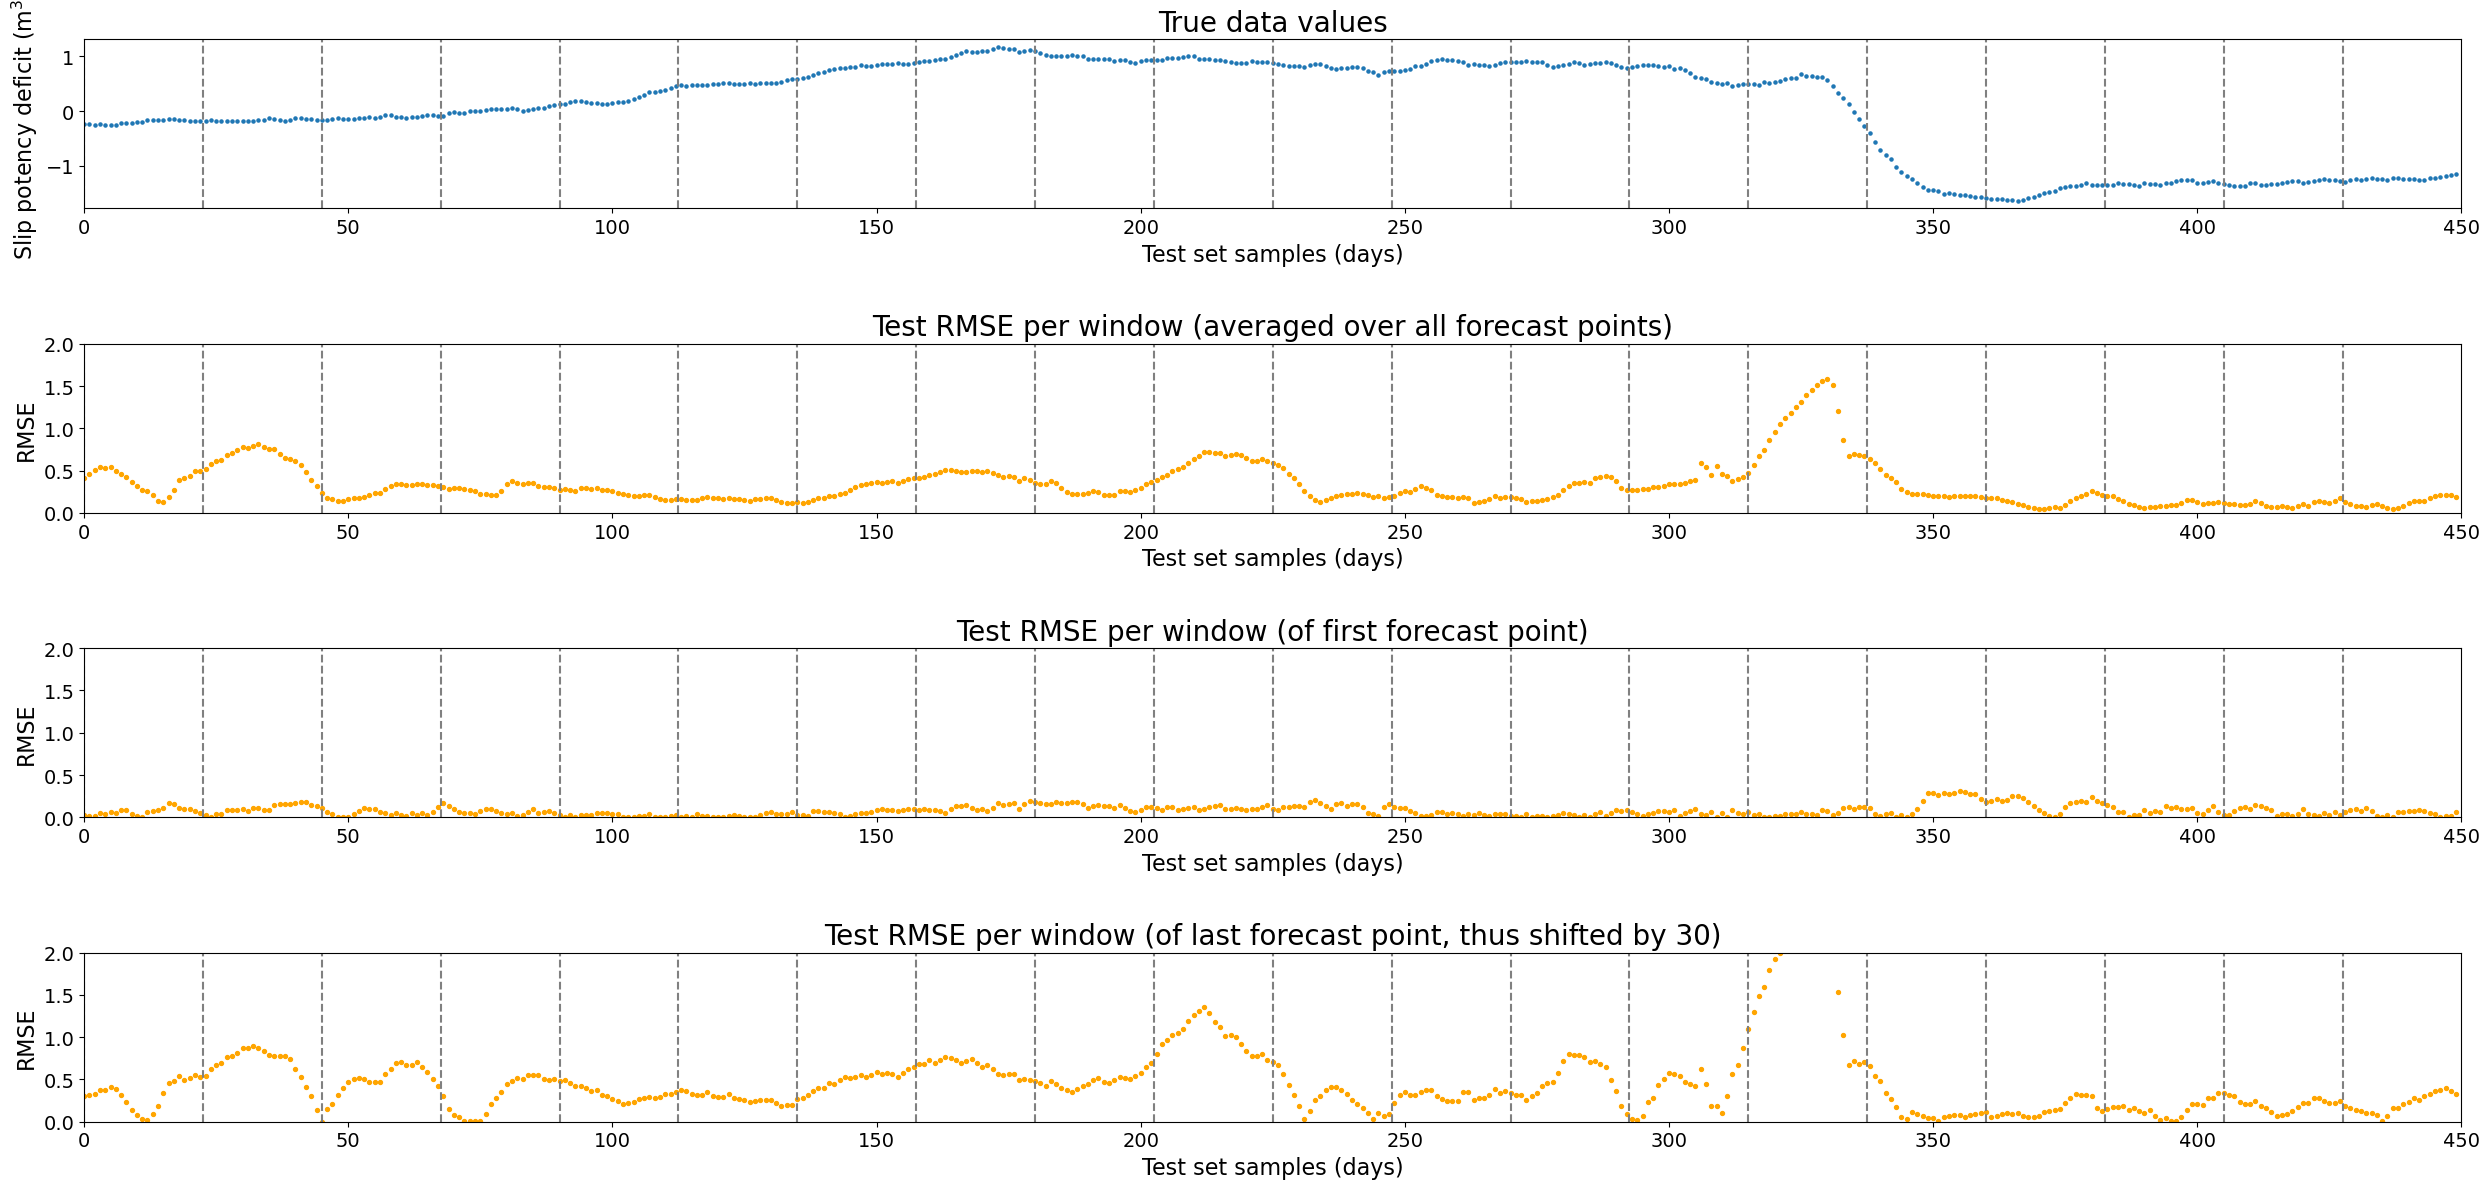

In [33]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 1, figsize=(25, 12))
n_samples = len(data_dict["y_test"])

# First subplot
for x in np.arange(0, n_samples, n_samples / 20):
    axs[0].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to first subplot
    axs[1].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[2].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[3].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot

axs[0].scatter(
    range(len(data_dict["y_test"][:, 0])),
    data_dict["y_test"][:, 0],
    s=5,
)
axs[0].set_title("True data values", fontsize=20)  # Add a title
axs[0].set_xlabel(X_LABEL, fontsize=16)  # Set X-axis label
axs[0].set_ylabel(Y_LABEL, fontsize=16)  # Set Y-axis label
axs[0].set_xlim([0, len(data_dict["y_test"][:, 0])])
axs[0].tick_params(axis="x", labelsize=14)
axs[0].tick_params(axis="y", labelsize=14)


rmse_ymax = 2

# Loop over the remaining subplots to set their properties
for i, (data, title) in enumerate(
    zip(
        [avg_test_rmse, test_rmse_first, test_rmse_last],
        [
            "Test RMSE per window (averaged over all forecast points)",
            "Test RMSE per window (of first forecast point)",
            f"Test RMSE per window (of last forecast point, thus shifted by {FORECAST})",
        ],
    )
):
    axs[i + 1].scatter(range(len(data)), data, s=8, color="orange")
    axs[i + 1].set_title(title, fontsize=20)
    axs[i + 1].set_xlabel(X_LABEL, fontsize=16)
    axs[i + 1].set_ylabel("RMSE", fontsize=16)
    axs[i + 1].set_ylim([0, rmse_ymax])
    axs[i + 1].set_xlim([0, len(data)])
    axs[i + 1].tick_params(axis="x", labelsize=14)
    axs[i + 1].tick_params(axis="y", labelsize=14)


plt.tight_layout()  # Adjust the layout to not overlap
plt.subplots_adjust(hspace=0.8)  # Adjust the horizontal spacing here
plt.show()

In [34]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

with torch.no_grad():
    loss = array_loss_fn(y_test_pred, y_test_true)

    avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
    test_rmse_first = np.sqrt(loss[:, 0])
    test_rmse_last = np.sqrt(loss[:, -1])

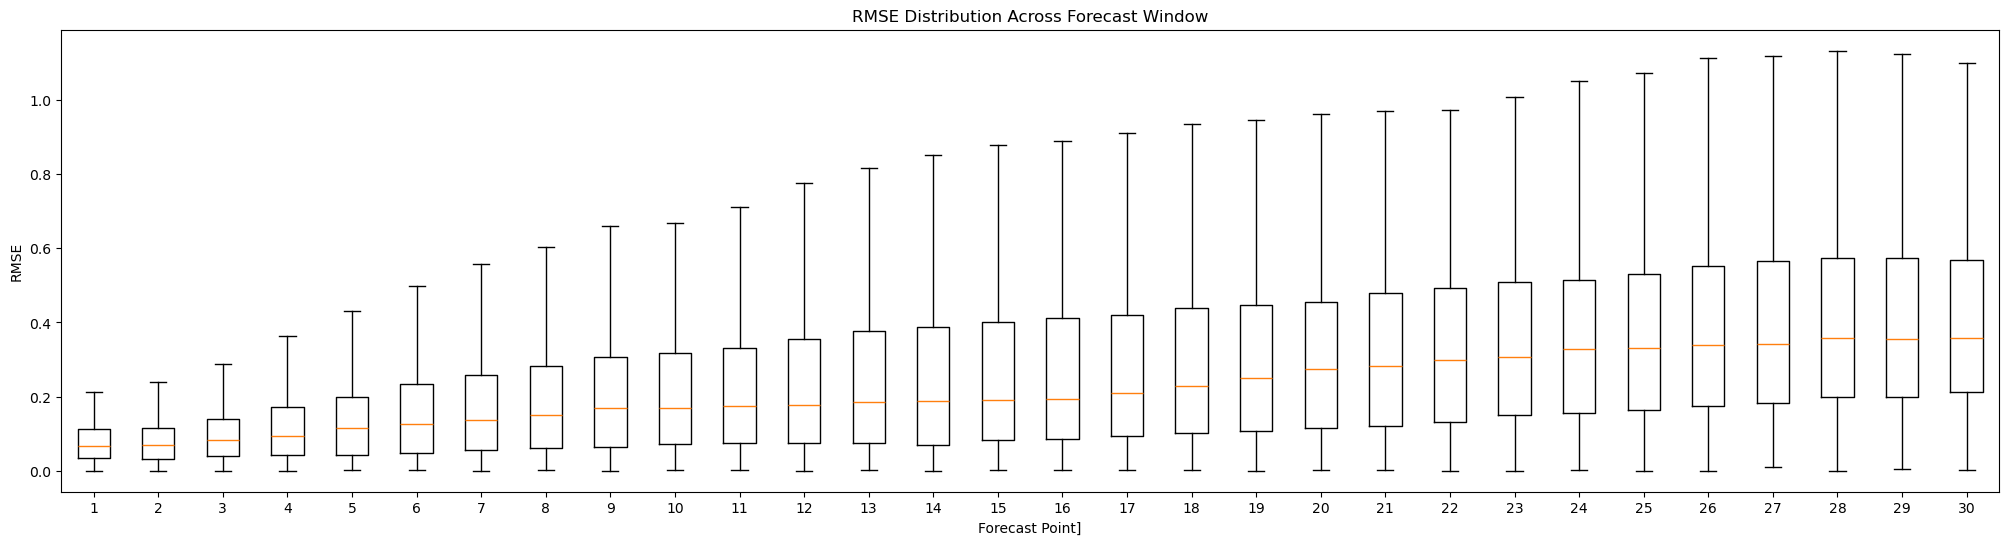

In [35]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(25, 6))
plt.boxplot(rmse.numpy(), showfliers=False)
ax.set_title("RMSE Distribution Across Forecast Window")
ax.set_xlabel("Forecast Point]")
ax.set_ylabel("RMSE")
ax.set_xticklabels([i + 1 for i in range(rmse.shape[1])])  # Label each boxplot
plt.show()